In [1]:
import os, sys
sys.path.insert(1, os.getcwd()) 
sys.path.append("..")

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from typing import Callable, Tuple

In [12]:
from uilc.methods import pw
from uilc.radiation import lambertian
from uilc.utils.misc import d2, extend_signal
from uilc.utils.misc import extend_signal

import numpy as np
from matplotlib import pyplot as plt
from typing import Callable, Tuple
from scipy import signal
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq, ifft
from copy import deepcopy

In [4]:
#Optical system setting
cm = 1E-2
s = 30
W = 5*cm
H = 2*cm

In [27]:
pw.nmax(s, W, H)

14

In [62]:
delta, position, F = pw.solve_system(s, W, H,set_nmax=True)
delta2, position2, F2 = pw.solve_system(s, W, H, dim =50, set_nmax=False )

In [63]:
delta2.shape

(50,)

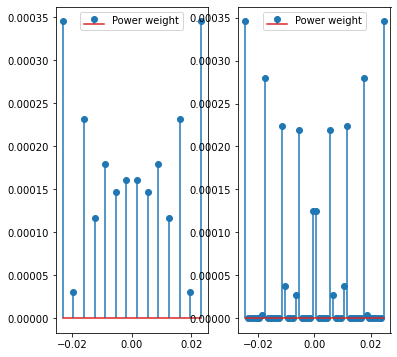

In [64]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot(1, 2, 1)
ax.stem(position, delta)
ax.legend(["Power weight"])
ax2 = figure.add_subplot(1, 2, 2)
ax2.stem(position2, delta2)
ax2.legend(["Power weight"])
plt.show()

In [14]:
from uilc.utils.misc import extend_signal

from scipy import signal
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq, ifft
from copy import deepcopy

In [71]:
N = 50
def resample_n(sig, time, N, rate=240):
    W = time.max()-time.min()
    sig_ext, time_ext = extend_signal(sig, time, n=N, period =None, central=True)
    sig_resample = signal.resample(sig_ext, N*rate)
    time_resample = pw.position_array(N*W, N*rate) + 0.5*W
    return sig_resample, time_resample



In [76]:
delta_resample, position_resample =resample_n(delta, position, N, rate =240)
delta_resample2, position_resample2 =resample_n(delta2, position2, N, rate =240)

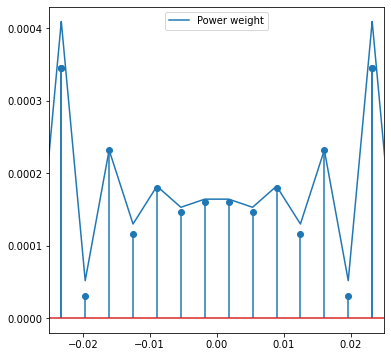

In [74]:
figure= plt.figure(figsize=(6,6))
ax = figure.add_subplot(1, 1, 1)
ax.stem(position_ext, delta_ext)
ax.plot(position_ext, np.abs(signal.hilbert(delta_ext)))
ax.set_xlim([-W/2, W/2])
ax.legend(["Power weight"])
plt.show()

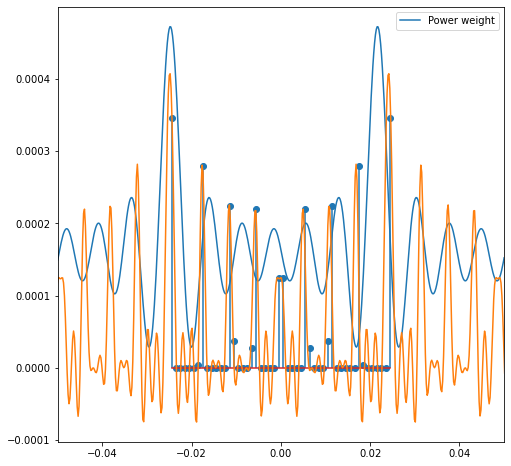

In [79]:
figure= plt.figure(figsize=(8,8))
ax = figure.add_subplot(1, 1, 1)
#ax.stem(position_ext, delta_ext)
ax.stem(position2, delta2)
ax.plot(position_resample, delta_resample)
ax.plot(position_resample2, delta_resample2)
ax.set_xlim([-W, W])
ax.legend(["Power weight"])
plt.show()

$$N_i\\
N_i +1 \\
N_i +2 \\
N_i +3 \\
N_i +4$$

In [ ]:
from scipy.fft import fft, fftfreq, ifft
from copy import deepcopy

In [202]:
def resample_n(sig, time, N, rate=240):
    W = time.max()-time.min()
    sig_ext, time_ext = extend_signal(sig, time, n=N, period =None, central=True)
    sig_resample = signal.resample(sig_ext, N*rate)
    time_resample = pw.position_array(N*W, N*rate)
    return sig_resample, time_resample
def signal_decomposition(sig, pos, thersholf_freq, return_type=True):
    N = len(pos)
    T = pos[1]-pos[0]

    sig_f = fft(sig)
    x_f = fftfreq(N ,T)

    sig_low = deepcopy(sig_f)
    sig_low[np.where( np.fabs(x_f) > thersholf_freq)] =  0
    sig_high = deepcopy(sig_f)
    sig_high[np.where( np.fabs(x_f) <= thersholf_freq)] =  0

    if return_type:
        return ifft(sig_low), ifft(sig_high)
    else:
        return (sig_low, x_f), (sig_high, x_f)

In [203]:
cm = 1E-2
s = 20
W = 5*cm
H = 2*cm
nmax = pw.nmax(s, W, H)
N = 30
rate = 480

In [204]:
sample_dim = [nmax+i*10 for i in range(0, 3)]
power_weights = [pw.solve_system(s, W, H, dim =n, set_nmax=False)[0:2] for n in sample_dim]
resamples = [ resample_n(delta, pos, N, rate) for delta, pos in power_weights]
sig_decoms = [signal_decomposition(sig, pos, 2*np.pi/W) for sig, pos in resamples]

In [205]:
def task1(N, s, W, H, ext_n, rate):
    delta, pos, K = pw.solve_system(s, W, H, N, set_nmax=False)
    sig_ext, pos_ext =resample_n(delta, pos ,ext_n, rate)
    a, b = signal_decomposition(sig_ext, pos_ext, 2*np.pi/W, return_type=False) 
    sig_low, xf1 =a 
    sig_high, xf2 = b 
    return xf1, sig_low, sig_high

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


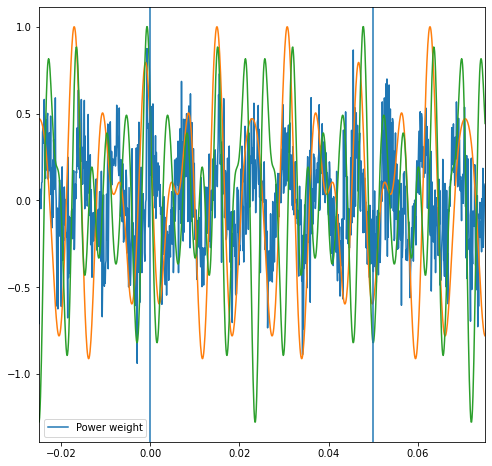

In [206]:
figure= plt.figure(figsize=(8,8))
ax = figure.add_subplot(1, 1, 1)
for sig_dem, sample in zip(sig_decoms, resamples):
    m = sig_dem[1].max()
    ax.plot(sample[1], sig_dem[1]/m)

ax.axvline(x= W)
ax.axvline(x= 0)
ax.set_xlim([-W/2, W*1.5])
ax.legend(["Power weight"])
plt.show()

In [207]:
sig_decoms_f = [signal_decomposition(sig, pos, 2*np.pi/W, return_type=False) for sig, pos in resamples]

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


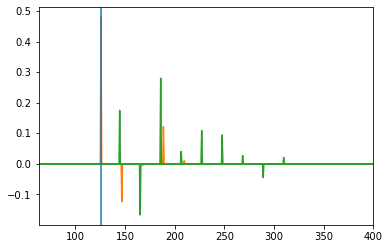

In [208]:
fig = plt.figure()
ax = fig.add_subplot()
for sig_low, sig_high in sig_decoms_f:
    ax.plot(sig_high[1], sig_high[0])
ax.set_xlim([ np.pi/W, 400])
ax.axvline(2*np.pi/W)
plt.show()

In [209]:
sig_low[0]

array([ 9.51697713e-01-0.00000000e+00j,  6.23964536e-18-6.57432547e-18j,
       -1.43901772e-19-1.42960519e-18j, ...,
       -8.48760607e-19+7.08679211e-19j, -1.43901772e-19+1.42960519e-18j,
        6.23964536e-18+6.57432547e-18j])

In [210]:
B = 2*np.pi/W
rect_sig = 2*B*np.sinc(2*np.pi*B * pos)

In [211]:
sig1 = deepcopy(sig_f)
sig1[np.where( np.fabs(x_f) > (1.2)*np.pi/W)] =  0
sig2 = deepcopy(sig_f)
sig2[np.where( np.fabs(x_f) <= (1.2)*np.pi/W)] =  0

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


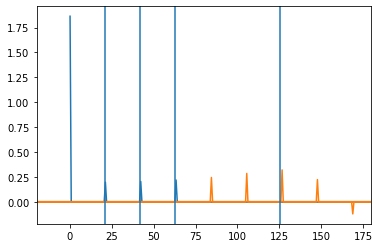

In [212]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_f, sig1)
ax.plot(x_f, sig2)
ax.set_xlim([-20, 180])
L = [1, 2, 3, 6]
for n in L:
    ax.axvline(2*np.pi/(n*W))
#ax.axvline(2*np.pi/W)
#ax.axvline(np.pi/W)
plt.show()

In [213]:
from scipy.signal import find_peaks

In [214]:
sig_low = ifft(sig1)
sig_high = ifft(sig2)

In [215]:
peaks_x, _ = find_peaks(sig1)
peaks = sig1[peaks_x]

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


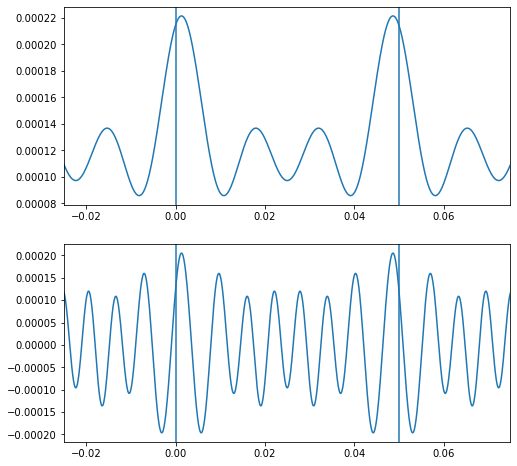

In [216]:
resi = 0.05*W
figure= plt.figure(figsize=(8,8))
ax1 = figure.add_subplot(2, 1, 1)
ax2 = figure.add_subplot(2, 1, 2)
ax1.plot(pos+resi, sig_low)
ax1.axvline(x= W)
ax1.axvline(x= 0)
ax1.set_xlim([-W/2, W*1.5])
ax2.plot(pos+resi, sig_high)
ax2.axvline(x= W)
ax2.axvline(x= 0)
ax2.set_xlim([-W/2, W*1.5])
#ax.legend(["Power weight"])
plt.show()

Frequency Analysis

In [221]:
from uilc.methods import pw
from uilc.radiation import lambertian
from uilc.utils.misc import d2, extend_signal
from uilc.utils.misc import extend_signal

import numpy as np
from matplotlib import pyplot as plt
from typing import Callable, Tuple
from scipy import signal
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq, ifft
from copy import deepcopy

In [222]:
pw.nmax(s, W, H)

12

In [243]:
def resample_n(sig, time, N, rate=240):
    W = time.max()-time.min()
    sig_ext, time_ext = extend_signal(sig, time, n=N, period =None, central=True)
    sig_resample = signal.resample(sig_ext, N*rate)
    time_resample = pw.position_array(N*W, N*rate)
    return sig_resample, time_resample
def signal_decomposition(sig, pos, thersholf_freq, return_type=True):
    N = len(pos)
    T = pos[1]-pos[0]

    sig_f = fft(sig)
    x_f = fftfreq(N ,T)

    sig_low = deepcopy(sig_f)
    sig_low[np.where( np.fabs(x_f) > thersholf_freq)] =  0
    sig_high = deepcopy(sig_f)
    sig_high[np.where( np.fabs(x_f) <= thersholf_freq)] =  0

    if return_type:
        return ifft(sig_low), ifft(sig_high)
    else:
        return (sig_low.real, x_f), (sig_high.real, x_f)

In [269]:
def task1(N, s, W, H, ext_n, rate):
    delta, pos, K = pw.power_weight(s, W, H, N, set_nmax=False)
    delta = delta/delta.max()
    sig_ext, pos_ext =resample_n(delta, pos ,ext_n, rate)
    a, b = signal_decomposition(sig_ext, pos_ext, 2*np.pi/W, return_type=False) 
    sig_low, xf1 =a 
    sig_high, xf2 = b 
    return xf1, sig_low, sig_high

In [395]:
#Optical system setting
cm = 1E-2
s = 2
W = 5*cm
H = 2*cm

In [396]:
nmax = pw.nmax(s, W, H)
print(nmax)

5


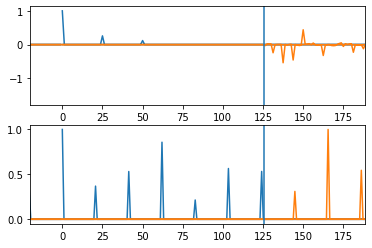

In [397]:
#ns = [nmax, int(1.5*nmax), int(3*nmax), int(4*nmax), int(6*nmax)]
ns  = [nmax, 6*nmax]
plot_data = [task1(n, s, W, H, ext_n=20, rate =240) for n in ns]
fig = plt.figure()
row = len(plot_data)
for i, (xf, sig_low, sig_high) in enumerate(plot_data):
    ax = fig.add_subplot(row, 1, i+1)
    ax.plot(xf, sig_low/sig_low.max())
    ax.plot(xf, sig_high/sig_high.max())
    ax.set_xlim([-20, 3*np.pi/(W)])
    ax.axvline(2*np.pi/W)
L = [1, 2, 3, 6]
#for n in L:
#    ax.axvline(2*np.pi/(n*W))

#ax.axvline(np.pi/W)
plt.show()

(-0.025, 0.025)

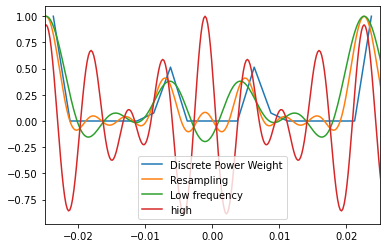

In [398]:
delta, pos, K = pw.solve_system(s, W, H, dim = int(4*nmax), set_nmax=False)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pos, delta/delta.max())
si, t = resample_n(delta, pos, 3)
si_low, si_high = signal_decomposition(si, t, 2*np.pi/W)
si_low = si_low.real
si_high = si_high.real
ax.plot(t, si/si.max())
ax.plot(t, si_low/si_low.max())
ax.plot(t, si_high/si_high.max())
ax.legend(["Discrete Power Weight", "Resampling", "Low frequency", "high"])
ax.set_xlim([-W/2, W/2])


In [399]:
from scipy.signal import find_peaks


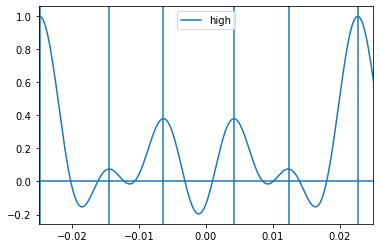

In [400]:
ind_low, _ =find_peaks(si_low)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, si_low/si_low.max())
ax.legend(["high"])
for i in ind_low:
    ax.axvline(x = t[i])
ax.set_xlim([-W/2, W/2])
ax.axhline(y=0)

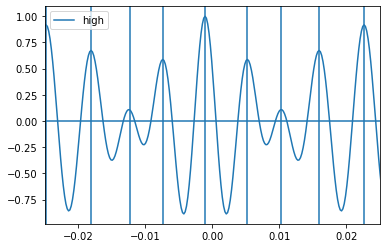

In [401]:
ind_high, _ =find_peaks(si_high, distance=25)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, si_high/si_high.max())
ax.legend(["high"])
for i in ind_high:
    ax.axvline(x = t[i])
ax.set_xlim([-W/2, W/2])
ax.axhline(y=0)


In [426]:
source_induced_low = [t[i] for i in ind_low]  
r = (source_induced_low[-1] - source_induced_low[0])/2
ds  =source_induced_low[0] + r
source_induced_low = [s - ds for s in source_induced_low]
source_induced_low = [x for x in source_induced_low if x>=-1.5*W/2 and x<=1.5*W/2]

In [402]:
source_induced_high = [t[i] for i in ind_high] 
source_induced_high = [x for x in source_induced_high if x>=-W/2 and x<=W/2] 


In [403]:
def lamber(xarr, sources, s, W, H):
    result = np.zeros(xarr.shape)
    for s in sources:
        result += H**s/((s - xarr)**2 + H**2)**(s/2+1)
    return result

In [420]:
source_induced_low += [-W/2, W/2]
#source_induced_high += [-W/2, W/2]

In [437]:
#dt = -(source_induced_low[2] + source_induced_low[3])/2
source_induced_low = [ s+ dt for s in source_induced_low]

In [441]:
source_induced_low = source_induced_low[1:-1]

In [443]:
d_m = source_induced_low[0]
d_ma = source_induced_low[-1]
dt  = (d_m+d_ma)/2
source_induced_low = [s -dt for s in source_induced_low]

In [445]:
source_induced_low += [-W/2, W/2]

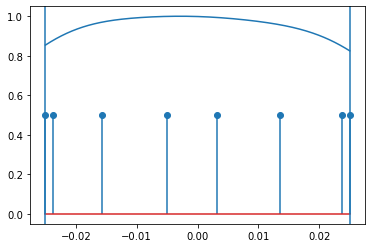

Mean, Max, Min/Max, std/Max
0.9564, 1.0000, 0.8248, 0.0453


In [446]:
# Low frequncy result
xarr = np.linspace(-W/2, W/2, 400, endpoint=True)
y_rad = lamber(xarr, source_induced_low, s, W, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source_induced_low, 0.5*np.ones(len(source_induced_low)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


In [440]:
source_induced_low[1:-1]

[-0.022500000000000006,
 -0.014385416666666671,
 -0.003697916666666669,
 0.004416666666666659,
 0.01470833333333333,
 0.025]

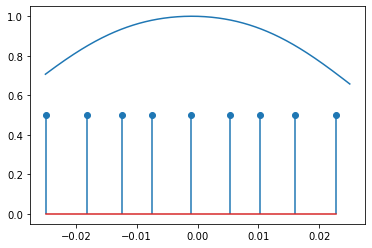

Mean, Max, Min/Max, std/Max
0.8930, 1.0000, 0.6574, 0.0976


In [404]:
# high frequncy result
xarr = np.linspace(-W/2, W/2, 400, endpoint=True)
y_rad = lamber(xarr, source_induced_high, s, W, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source_induced_high, 0.5*np.ones(len(source_induced_high)))
ax.plot(xarr, y_rad)
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


---

(-0.03, 0.03)

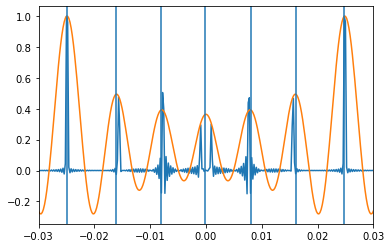

In [323]:
fig = plt.figure()
ax = fig.add_subplot()
si, t = resample_n(delta, pos, 3)
si_low, si_high = signal_decomposition(si, t, 2*np.pi/W)
si_low = si_low.real
si_high = si_high.real
ind, _ =find_peaks(si_low)
ax.plot(t, si/si.max())
ax.plot(t, si_low/si_low.max())
for i in ind:
    ax.axvline(x = t[i])
ax.set_xlim([-1.2*W/2, 1.2*W/2])

In [324]:
ext_x = [t[i] for i in ind]

In [326]:
dim_n = len(ext_x)

In [327]:
dif_m = pw.diff_matrix(dim_n)

In [336]:
dif_x = dif_m.dot(ext_x)
dif_x_r = dif_x[1:]
dif_x_r = dif_x_r - dif_x_r.mean()
dif_x_r = 100* dif_x_r/W

In [337]:
dif_x_r

array([-0.28521286, -0.70006793, -0.28521286, -0.28521286,  0.95935236,
        1.37420743, -0.28521286, -0.70006793, -0.28521286, -0.28521286,
        0.95935236,  1.37420743, -0.28521286, -0.70006793, -0.28521286,
       -0.28521286])

Power weight map with number calculation.

1. Calculate power weight.
2. Normalization, Extending, Resampling.
3. Applying Low/high pass filter with band: $f_b = \frac{2 \pi}{W}$.


### Power weighting

$n$: number of the peaks after (3), 
${w_i}_{i=1}^n$: peak values.

Source location = peak location

### Distribution

Decompose into 


